In [8]:
from scwfae.data.ptbxlDS import PtbxlAllChanDS
from scwfae.model.ConvolutionalEcgModules import ConvolutionalEcgVAE
import torch
from torch.utils.data import random_split, DataLoader

torch.manual_seed(42)

In [9]:
ds = PtbxlAllChanDS(lowres=True)
_, val_ds = random_split(ds, lengths=[0.9, 0.1])
val_dl = DataLoader(val_ds, batch_size=len(val_ds))

sig, labels = next(iter(val_dl))
sig.shape

torch.Size([1886, 12, 1000])

In [10]:
m = ConvolutionalEcgVAE.load('cache/savedmodels/ecgvae.pt').to('cuda')
m.eval()
m

ConvolutionalEcgVAE(
  (encoder): ConvolutionalEcgEncoder(
    (net): Sequential(
      (0): Conv1d(1, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(16, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv1d(16, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv1d(16, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (7): LeakyReLU(negative_slope=0.01)
      (8): Conv1d(16, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (9): LeakyReLU(negative_slope=0.01)
      (10): Conv1d(16, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (11): LeakyReLU(negative_slope=0.01)
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=256, out_features=20, bias=True)
      (14): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): ConvolutionalEcgDecoder(
    (net): Sequential(
      (0):

In [12]:
n, channels, sig_len = sig.shape

with torch.no_grad():
    encodings = m.vae_encode(sig.view(n* channels, sig_len).unsqueeze(1).to('cuda'))
    
encodings = encodings.view(n, channels * m.architecture_params.latent_dim)
encodings.shape


torch.Size([1886, 240])

In [13]:

from torch.nn.functional import mse_loss

with torch.no_grad():
    reconstructions, _, _ = m(sig.view(n* channels, sig_len).unsqueeze(1).to('cuda'))
    
mse_loss(reconstructions, sig.view(n*channels, sig_len).unsqueeze(1).to('cuda'), reduction='mean')


tensor(0.0377, device='cuda:0')

In [14]:
# Add mse loss as another feature
losses = mse_loss(reconstructions, sig.view(n*channels, sig_len).unsqueeze(1).to('cuda'), reduction='none').mean(axis=-1)
avg_losses = losses.view(n, channels).mean(axis=-1)

encodings_with_losses = torch.cat([encodings, avg_losses.unsqueeze(-1)], axis=1)
encodings_with_losses.shape

torch.Size([1886, 241])

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for label_name, y in labels.items():
    if y.sum() > 10:
        clf = RandomForestClassifier(n_jobs=-1)
        scores = cross_val_score(clf, encodings_with_losses.detach().cpu().numpy(), y.detach().cpu().numpy(), cv=5, scoring='roc_auc')
        print(f"{label_name}: {scores.mean()}")
    else:
        print(f"Insufficient positive examples: {label_name}")

CD: 0.578421341527364
HYP: 0.7438469255991189
MI: 0.5333075367934834
NORM: 0.6071859768991147
STTC: 0.5403411071341566


<Axes: >

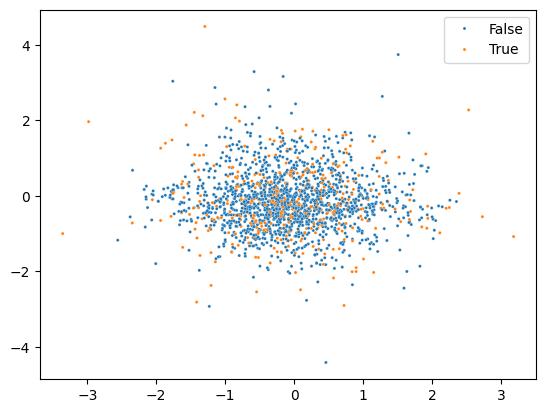

In [8]:
import seaborn as sns
# TODO: high dimensionality visulaizations
LOI = 'CD'

lead1 = encodings.view(n, channels, m.architecture_params.latent_dim)[:,0,:]
lead1.shape
sns.scatterplot(x=lead1[:, 0].detach().cpu().numpy(), y=lead1[:, 1].detach().cpu().numpy(), hue=labels[LOI].detach().cpu().numpy(), s=5)
